In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dowjones_closing = pd.read_csv('C:/Users/User/Desktop/Data Scientist/AML/Time_Series/Series/weekly-closings-of-the-dowjones-.csv')
airlines_passengers = pd.read_csv('C:/Users/User/Desktop/Data Scientist/AML/Time_Series/Series/international-airline-passengers.csv')

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        plt.tight_layout()
    return

In [5]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

In [6]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)
        
    return pd.Series(result)

In [7]:
def plot_dema(alpha, beta, ser, ser_to_plot, n_preds):
    dema = double_ema_with_preds(ser, alpha, beta, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='TEMA')
        plt.title('alpha={}, beta={}'.format(alpha, beta))
        plt.legend()

In [8]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [9]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [10]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [11]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds):
    tema = triple_exponential_smoothing(ser, 50, alpha, beta, gamma, n_preds)
    pred = np.empty(len(ser))
    pred[:] = np.nan
    pred = np.concatenate((pred, tema[-n_preds:]))
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.plot(pred, color='green', linewidth='4', label='prediction')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

Рассмотрим временной ряд закрытия индекса Доу-Джонса в нескольких вариантах: в оригинальном виде и приведённом к виду, по которому тест Дики-Фуллера отвергает гипотезу о нестационарности. Применим к ним метод двойного экспоненциального сглаживания или метод Хольта-Винтерса.

___

Первый вариант - в оригинальном виде.

In [12]:
series1 = dowjones_closing['Close']

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


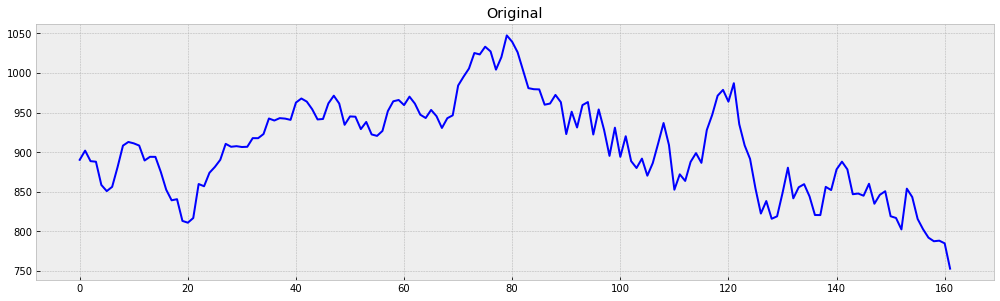

In [13]:
tsplot(series1)

Как видим, ряд является нестационарным.  
Будем считать, что в ряде отсутствует компонента - сезонность, поэтому приблизим его методом двойного экспоненциального сглаживания. Обучим модель на тренировочных данных, спрогнозируем на длину тестовых данных и сравним прогноз с тестовыми данными.

In [19]:
train1, test1 = series1[:140], series1[140:]

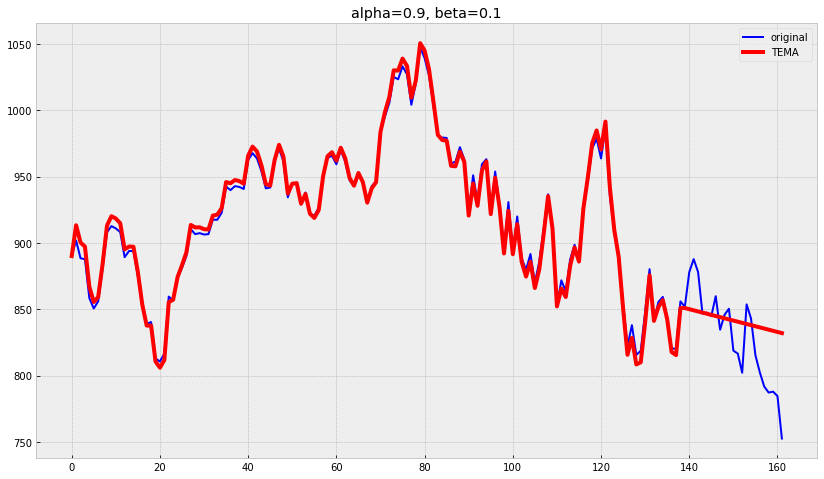

In [24]:
plot_dema(0.9, 0.1, train1, series1, len(test1))

Модель c параметрами $\alpha=0.9, \beta=0.1$ достаточно точно описала данные по которым обучилась, но спрогнозировала тестовые данные неточно и линейно.  
Попробуем найти оптимальные параметры относительно MSE ошибки модели и посмотрим на прогноз.

In [20]:
def mse_dema1(X):
    alpha, beta = X
    result = double_ema_with_preds(train1, alpha, beta, len(test1))
    predictions = result[-len(test1):]
    error = mean_squared_error(predictions, test1)
    return error

In [21]:
opt1 = minimize(mse_dema1, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [22]:
alpha_opt, beta_opt = opt1.x

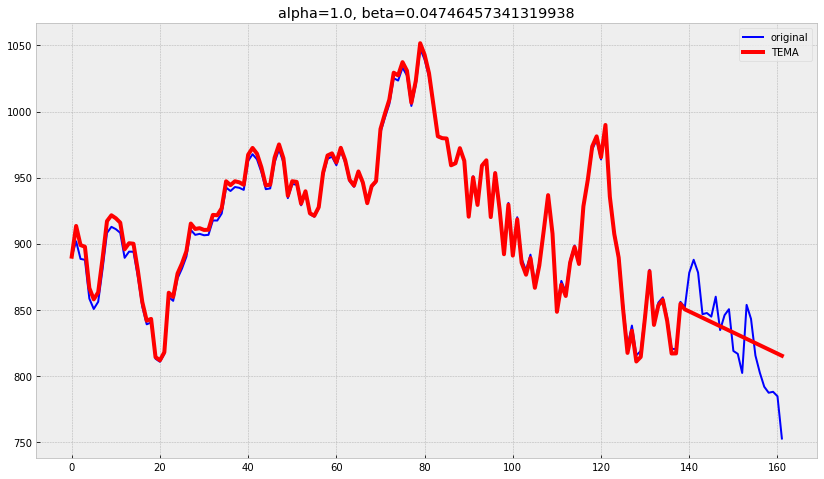

In [23]:
plot_dema(alpha_opt, beta_opt, train1, series1, len(test1))

Прогноз практически не изменился.

___

Второй вариант - удалим тренд.

In [14]:
series2 = series1.values[2:] - 2 * series1.values[1:-1] + series1.values[:-2]

Results of Dickey-Fuller Test:
Test Statistic                  -5.043437
p-value                          0.000018
#Lags Used                      14.000000
Number of Observations Used    145.000000
Critical Value (1%)             -3.476273
Critical Value (5%)             -2.881688
Critical Value (10%)            -2.577513
dtype: float64


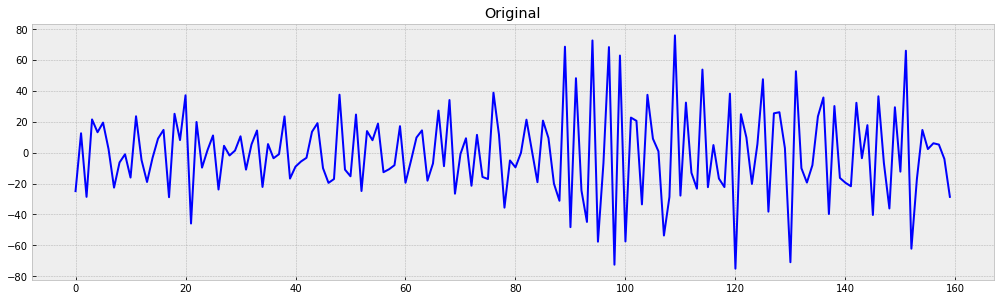

In [15]:
tsplot(series2)

После удаления тренда, тест Дики-Фуллера отвергает гипотезу о нестационарности ряда. Сравним прогнозы модели с параметрами $\alpha=0.9, \beta=0.1$ и отимизированными относительно ошибки MSE.

In [25]:
train2, test2 = series2[:140], series2[140:]

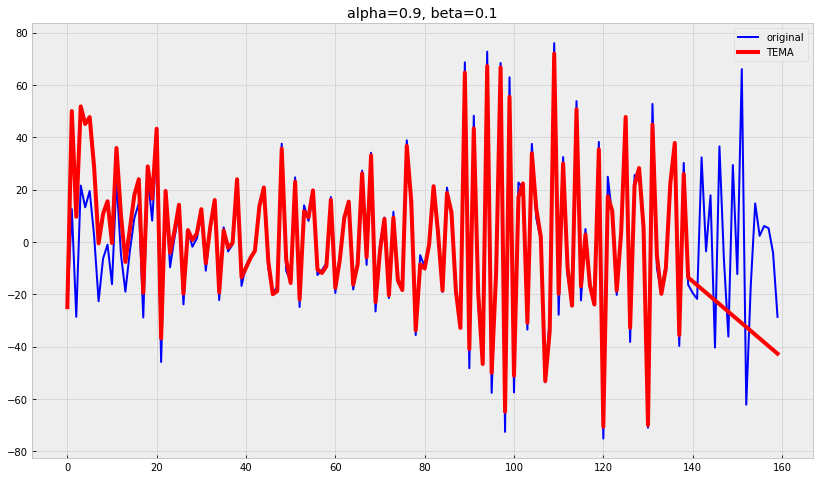

In [26]:
plot_dema(0.9, 0.1, train2, series2, len(test2))

In [27]:
def mse_dema2(X):
    alpha, beta = X
    result = double_ema_with_preds(train2, alpha, beta, len(test2))
    predictions = result[-len(test2):]
    error = mean_squared_error(predictions, test2)
    return error

In [28]:
opt2 = minimize(mse_dema2, x0=[0., 0.], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [29]:
alpha_opt, beta_opt = opt2.x

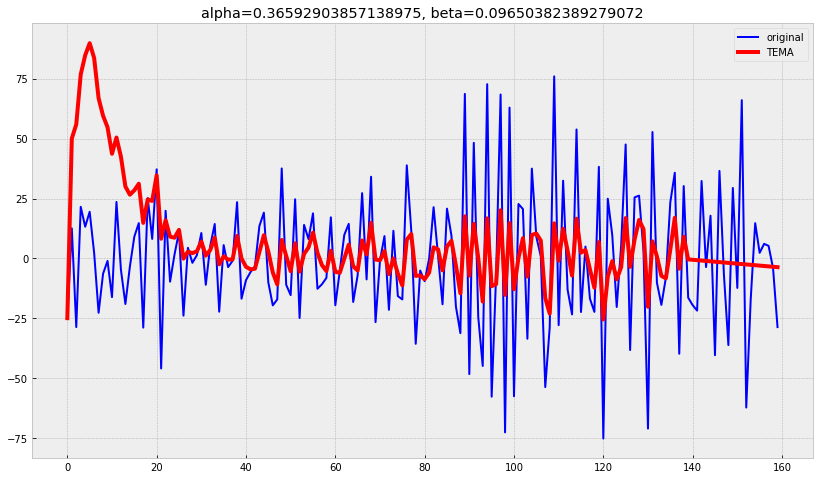

In [30]:
plot_dema(alpha_opt, beta_opt, train2, series2, len(test2))

Прогноз модели при оптимальных параметрах более точный, но также является линейным, также модель плохо описала данные, на которых обучилась.

___

Третий вариант - попробуем найти сезонность.

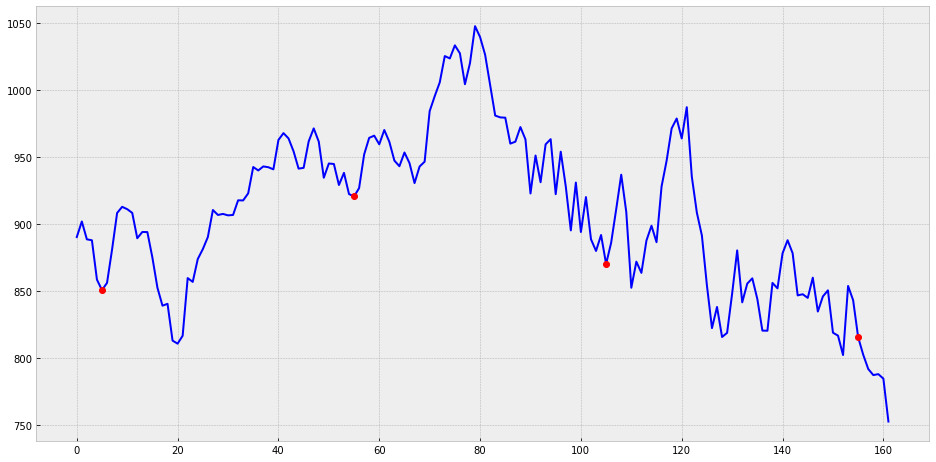

In [16]:
plot_ts_and_points(series1, 5, 50)

Предположим, что сезонность составляет 50 недель.  
  
1. Приблизим преобразованный ряд без тренда и сезонности методом двойного экспоненциального сглаживания с подобранными по MSE параметрами и посмотрим на прогноз.

In [17]:
series3 = series2[50:] - series2[:-50]

Results of Dickey-Fuller Test:
Test Statistic                -5.940835e+00
p-value                        2.263062e-07
#Lags Used                     1.300000e+01
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64


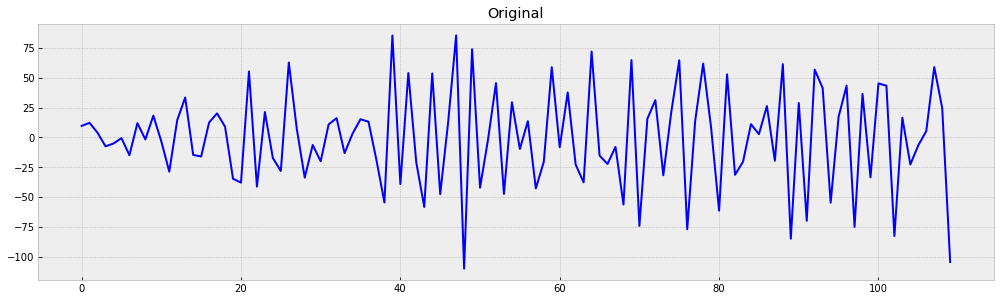

In [18]:
tsplot(series3)

In [31]:
train2, test2 = series3[:90], series3[90:]
opt3 = minimize(mse_dema2, x0=[0.5, 0.5], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt, beta_opt = opt3.x

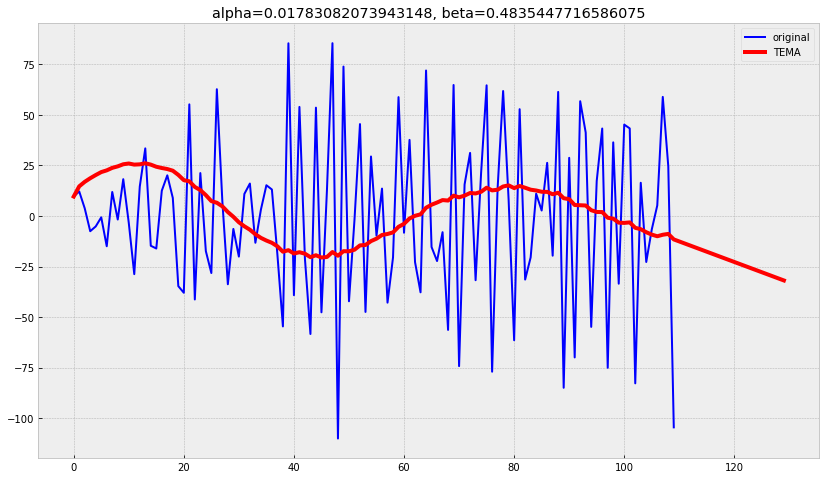

In [32]:
plot_dema(alpha_opt, beta_opt, series3, series3, len(test2))

Вряд ли прогноз стал лучше, т.к. описывается прямой линией с наклоном к горизонтальной оси, возле которой находятся значения ряда.

In [33]:
i = 0

In [34]:
train3, test3 = series1[:140], series1[140:]

2. Для приближения и прогноза ряда с сезонностью применим метод Хольта-Винтерса с параметрами $\alpha=0.1, \beta=0.1, \gamma=0.99$ и отимизированными по MSE.

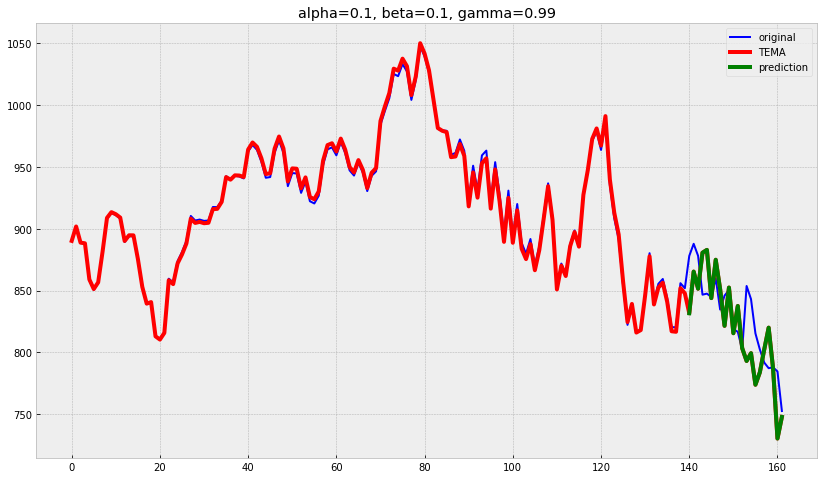

In [35]:
plot_tema(0.1, 0.1, 0.99, ser=train3, ser_to_plot=series1, n_preds=len(test3))

In [36]:
def mse_tema(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train3, 50, alpha, beta, gamma, len(test3))
    predictions = result[-len(test3):]
    error = mean_squared_error(predictions, test3)
    return error

In [37]:
opt3 = minimize(mse_tema, x0=[0.5, 0.5, 0.5], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [38]:
alpha_opt, beta_opt, gamma_opt = opt3.x

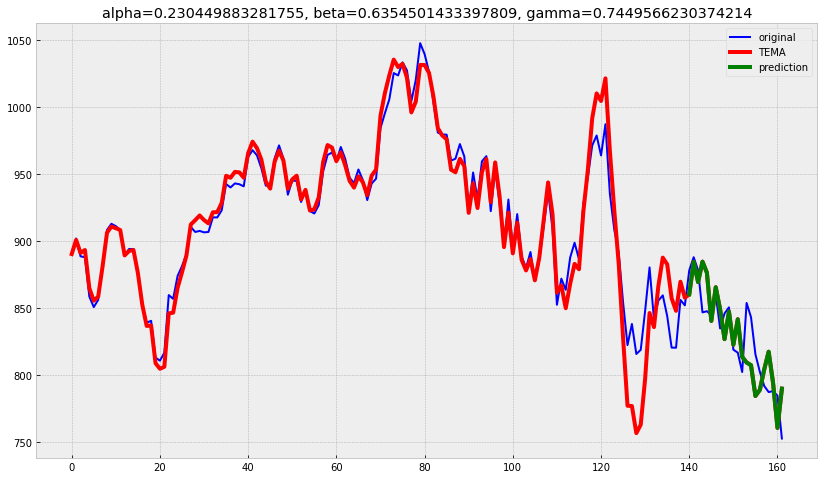

In [39]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train3, ser_to_plot=series1, n_preds=len(test3))

Прогноз стал более правдободобным.  
Сделаем прогноз на длину сезона с помощью модели с оптимальными параметрами, обучившись на всех данных ряда.

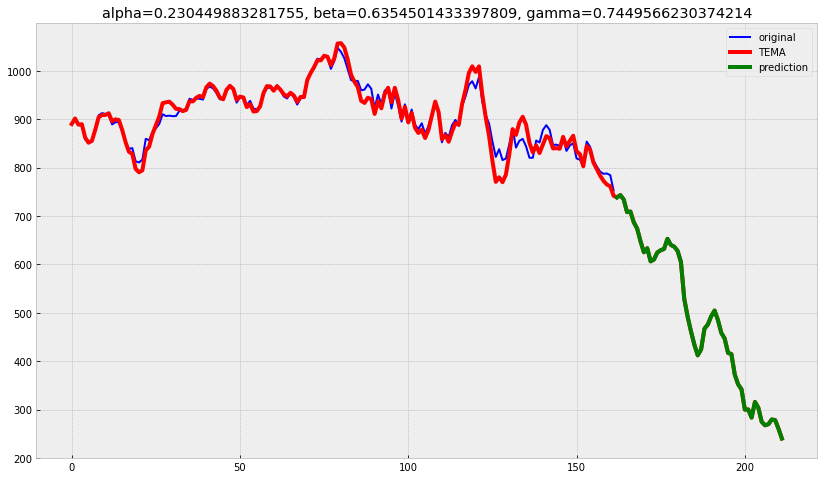

In [40]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series1, ser_to_plot=series1, n_preds=50)